-> In this code, to save memory, I have read and stored the directories of all the images at 256x256 in a numpy array.

-> 21000 images : 30 images are being taken from every folder. The first one is the face-on. So 29 unique oriented images, at different inclination angles and posang. 30x700 = 21000 images (SOURCE IMAGES). Corresponding to every source image, I have the corresponding face-on image, so that's another array with directories of 21000 images (TARGET IMAGES).

-> The source images are then being deployed and generated images are obtained, and compared with the corresponding target image. The network is being trained to generate images similar to their corresponding target image. 

-> The summarize_performance function is called at certain intervals to save a version of the model and a plot at that point in time. I am saving them inside a folder which happens to be unique for each entire run. The creation and naming of folders is done automatically.

-> Finally, we may choose any of the saved models' name and deploy it to give us the desired result.

____

# Generative Network to rotate and obtain face-on PPD images
## SOURCE CODE
### Inference Script

    This notebook is dedicated to performing inference using a Conditional Generative Adversarial Network (cGAN) incorporating the Pix2Pix concept, trained on a dataset of Protoplanetary Disk images obtained from the FARGO3D simulations. The primary goal of this project is to generate face-on images of Protoplanetary Disks from images that are rotated in random orientations.

    
    Summary       : The aim of this notebook is to utilize the trained cGAN models, particularly the Pix2Pix 
                    architecture, to transform images of Protoplanetary Disks with random orientations into 
                    standardized face-on images. This inference step is crucial for various astronomical 
                    studies and simulations where consistent orientation of disk images is required for 
                    accurate analysis.


    Code&Config   : The code is being done on Jupyter Notebook platform, and is being run on MacOS 13.1, 
                    Apple M1, 8gb configuration.  
               
         
________________

### Supervisor   : Dr. Sayantan Auddy
#### Written by    : Dyutiman Santra
#### Created       : 29th June, 2024

_______________________________________

||  Importing Modules  ||

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob 

#*****************

from sklearn.model_selection import train_test_split

from numpy import asarray
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import vstack

#*****************

import time
import sys

import random
from datetime import datetime as dt
from IPython import display
from PIL import Image


||  Checking the availbale number of GPUs  ||

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:",gpu.name,"Type:",gpu.device_type)
print("TensorFlow version used ",tf.__version__)

Num GPUs Available:  1
Name: /physical_device:GPU:0 Type: GPU
TensorFlow version used  2.10.0


_______


# Specifications

In [4]:
# To specify our requirements

no_o_folders = 700        #to set the number of folders (total 700)
pxl = 128                #to set the desired pixel value
channel = 1             #to set channel, 1 for grayscale and 3 for coloured

import ImageRotation_NetworkScript as NN

csv_directory = '/Users/Dyutiman/Documents/ML_Project/Pix2Pix/RT_Dataset_incl_posang.csv'
image_directory = '/Users/Dyutiman/Documents/ML_Project/Sayantan Da Projects/Final 1.5l'
sound_file_directory = '/Users/Dyutiman/Downloads/terminating alarm.mp3'


# with normal Mechanism
model_name_withoutAttention = 'modelWeight_20_24-06-30_16_01.h5'
model_path_withoutAttention = '/Users/Dyutiman/Documents/ML_Project/Pix2Pix/ModelWeight_24-06-30_16_01'

model_path_withoutAttention = model_path_withoutAttention + '/' + model_name_withoutAttention



# with ATTENTION Mechanism
model_name_withAttention = 'ATTN_modelWeight_10_24-07-10_04_34.h5'
model_path_withAttention = '/Users/Dyutiman/Documents/ML_Project/Pix2Pix/ATTN_ModelWeight_24-07-10_01_11'

model_path_withAttention = model_path_withAttention + '/' + model_name_withAttention

_______________

||  Reading DATA csv ||

In [5]:
df = pd.read_csv(csv_directory)  

# print(df,"\n")              #displaying csv

Ind, X_inlabel, Y_inlabel = [], [], []

Ind = df["index"]           #to store the image numbers excluding translational changes
X_label = df["incl"]        #to store the inclination angle
Y_label = df["posang"]      #to store the position angle

print("The dataframe is loaded.")

The dataframe is loaded.


||  Reading and loading DATA images ||

In [6]:
## Reading the Image Dataset, from specified folders

X = [] 															# a List to store oriented images
Y = [] 															# a List to store face-on image

k=0
m=0

print(f"Total number of folders to be loaded is {no_o_folders}.\n")

for i in range(1, no_o_folders+1):

    directory = image_directory +"/RT_A_"+ str(i)+"/*.png"
    data_set_indiv = glob.glob(directory)

    loc = image_directory +"/RT_A_"+ str(i)
    
    for j in Ind: #Loading the oriented images in X and correspondsing face-on images in Y
        X.append(loc+"/image_"+str(j)+".png")
        Y.append(loc+"/image_1.png")
        m = m+1
    
    k = k+1
    display.clear_output(wait=True)
    print("Total count of images = %d. ----> %2.2f %s"%(m,(k/no_o_folders)*100,'%'))

print(len(X), "image diretories are loaded.")

Total count of images = 21000. ----> 100.00 %
21000 image diretories are loaded.


____

In [7]:
# To display all the loaded images 
if (False):
    fig, axes = plt.subplots(ncols=1, sharex=False,sharey=True, figsize=(15, 5))

    k=0
    for i in X:
        try:
            axes.set_title("Run:{}".format(k))
            plt.imshow(cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB))
            k=k+1
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.001)
            if(k%2 == 0):
                fig, axes = plt.subplots(ncols=1, sharex=False,sharey=True, figsize=(15, 5))
        except KeyboardInterrupt:
            break


In [8]:
# Splitting the dataset
trainX, testX, trainy, testy = train_test_split(X, Y, random_state=42, test_size=0.10, shuffle=True)

# summarize the shape of the dataset
print('Train:', len(trainX), '\nTest:', len(testX), '\nTrainLabel:', len(trainy), '\nTestLabel:', len(testy))

Train: 18900 
Test: 2100 
TrainLabel: 18900 
TestLabel: 2100


_________________________________

# Loading Model

In [9]:
# defining input shape based on the loaded dataset
image_shape = (pxl,pxl,channel)
print("Shape is",image_shape)

# define the models
g_model_withoutAttention = NN.define_generator(image_shape)
g_model_withAttention    = NN.define_generator_with_attention(image_shape)
print("Working so far : g")


g_model_withoutAttention.load_weights(model_path_withoutAttention)
g_model_withAttention.load_weights(model_path_withAttention)


Shape is (128, 128, 1)
Metal device set to: Apple M1


2024-07-10 11:11:33.376026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 11:11:33.376730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow2/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Working so far : g


_________________________________

# Defining necessary functions 
(batch loading, computing indices, image plotting)

In [10]:
# loading a batch of images
def dataset_batch_test(lower, upper):
    TX = []
    TY = []

    for i in range(lower, upper):
        image_dir = testX[i]
        emag = cv2.imread(image_dir, channel//3)
        if(channel==1): emag = np.expand_dims(emag, axis=-1)
        TX.append(emag[57:428, 107:478])
#         emag = cv2.flip(emag[57:428, 107:478],1)
#         if(channel==1): emag = np.expand_dims(emag, axis=-1)
#         TX.append(emag)
        
        trg_dir = testy[i]
        emag = cv2.imread(trg_dir, channel//3)
        if(channel==1): emag = np.expand_dims(emag, axis=-1)
        TY.append(emag[57:428, 107:478])
#         emag = cv2.flip(emag[57:428, 107:478],1)
#         if(channel==1): emag = np.expand_dims(emag, axis=-1)
#         TY.append(emag)
        
#         if((i+1)%10 == 0):
        print("Loading batch %.2f%s (%d images)" % ((i+1-lower)/(upper-lower)*100,"%", (i+1)))
        display.clear_output(wait=True)
    
    tx = tf.image.resize(np.asarray(TX), [pxl, pxl])
    ty = tf.image.resize(np.asarray(TY), [pxl, pxl])

    T_X = tx.numpy()
    T_Y = ty.numpy()

    return [T_X,T_Y]

In [11]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2*mu1_mu2+C1)*(2*sigma12+C2))/((mu1_sq+mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2))
    
    return ssim_map.mean()

#calculate SSIM
def calculate_ssim(img1, img2):  # img1, img2: [0, 255]
    
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [12]:
#computing SSIM and MSE
def COMPUTE_DIFF(image1, image2):
    
    # Calculating Mean Squared Error (MSE)
    mse_value = np.mean((image1 - image2) ** 2)
    # Computing Structural similarity (SSIM) 
    ssim_value = ssim(image1, image2)
    
    return ssim_value, mse_value

In [13]:
# plotting source, generated and target images
def plot_images_single(src_img, ix, gen_img, tar_img):
    
    images = vstack((src_img, gen_img, tar_img))
    titles = ['Source (%d)'%ix, 'Generated', 'Expected']
    
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        plt.subplot(1, 3, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(images[i])
        # show title
        plt.title(titles[i])
        if( i==1 ):
            score1, diff1 = COMPUTE_DIFF(images[1], images[2])
#             plt.title(f"SSIM = {score:.2e} \nMSE = {diff:.2e} \n Generated")
            plt.title(f"SSIM = {score1:.3f} \nMSE = {diff1:.3f} \n {titles[i]}")

#____________________________________________________________________________________________________
    
# plotting source, generated (with and without Attention) and target images
def plot_images(src_img, ix, gen_img_withoutAttention, gen_img_withAttention, tar_img):
    
    images = vstack((src_img, gen_img_withoutAttention, gen_img_withAttention, tar_img))
    titles = ['Source (%d)'%ix, 'Generated', 'Generated (attention)', 'Expected']
    
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        plt.subplot(1, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(images[i])
        # show title
        plt.title(titles[i])
        if( i==1 ):
            score1, diff1 = COMPUTE_DIFF(images[1], images[3])
#             plt.title(f"SSIM = {score:.2e} \nMSE = {diff:.2e} \n Generated")
            plt.title(f"SSIM = {score1:.3f} \nMSE = {diff1:.3f} \n {titles[i]}")
        elif( i==2 ):
            score2, diff2 = COMPUTE_DIFF(images[2], images[3])
#             plt.title(f"SSIM = {score:.2e} \nMSE = {diff:.2e} \n Generated")
            plt.title(f"SSIM = {score2:.3f} \nMSE = {diff2:.3f} \n {titles[i]}")

________________________________________________

# LOADING DATASET ...

In [14]:
# Loading all the test images

[X1, X2] = dataset_batch_test(0,len(testX))

Loading batch 100.00% (2100 images)


_________________________________

# Generating face-on images

## Plot 1 (without Attention)

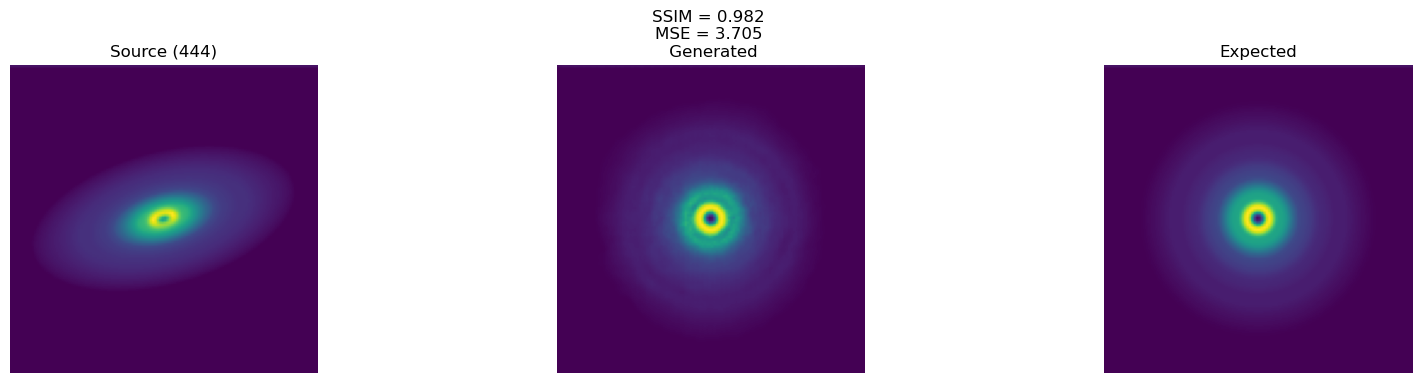

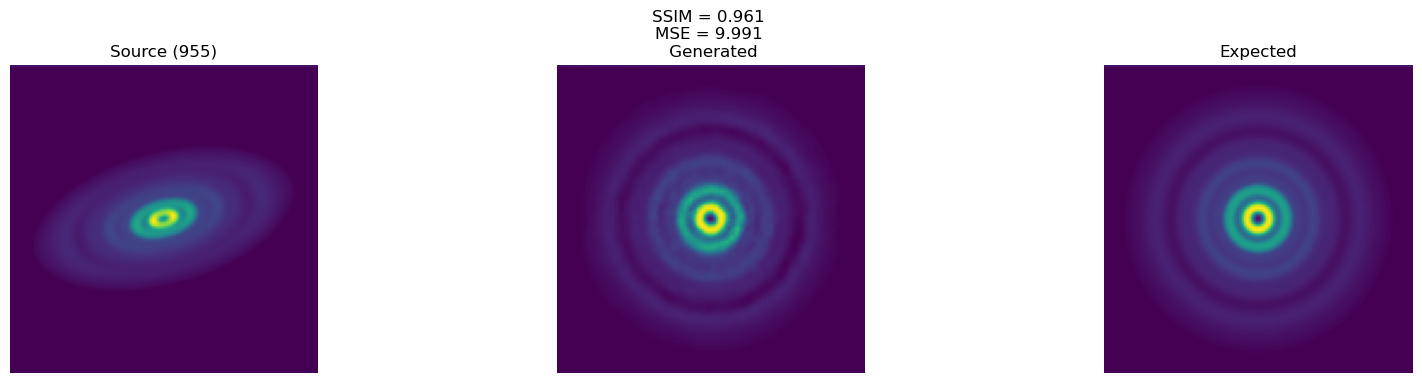

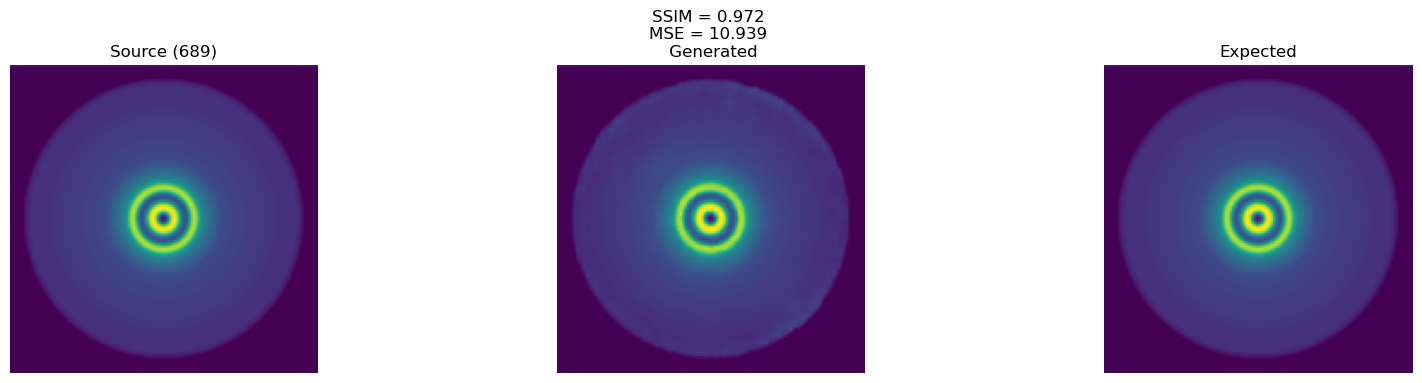

In [15]:
# Calling the plot function

for i in range(3):
    fig, axes = plt.subplots(ncols=3, sharex=False,sharey=True, figsize=(20, 4))
    
    # selecting random example
    ix = randint(0, len(X1), 1)
    # generate image from source
    gen_image_withoutAttention = g_model_withoutAttention.predict((X1[ix]-127.5)/127.5)
    # plot all three images
    plot_images_single(X1[ix], ix+1, (gen_image_withoutAttention+1)*255/2, X2[ix])
    
    display.clear_output(wait=True)

plt.show()

## We may use the previously generated CSV to choose images of specific orientation as our Source Images

_________________________________

## Plot 2 (with Attention)

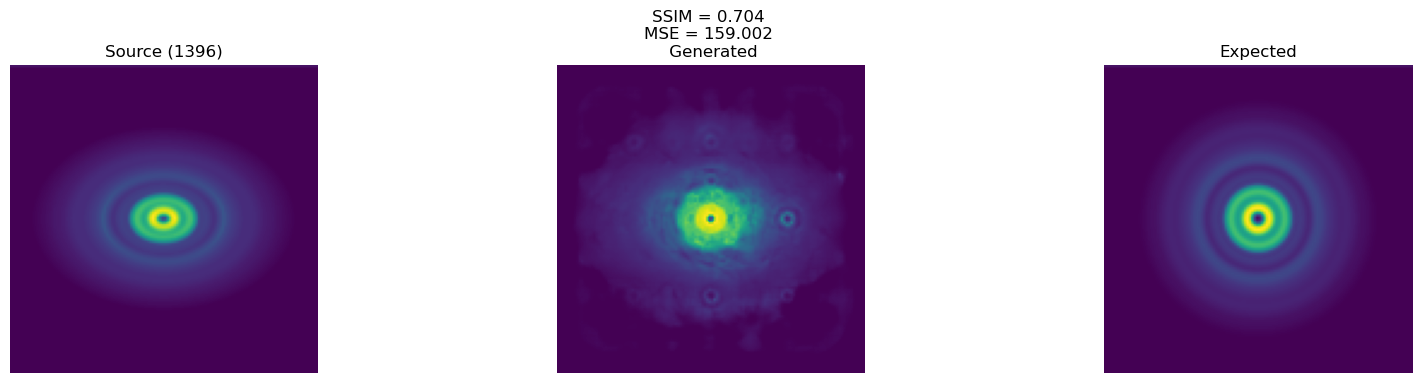

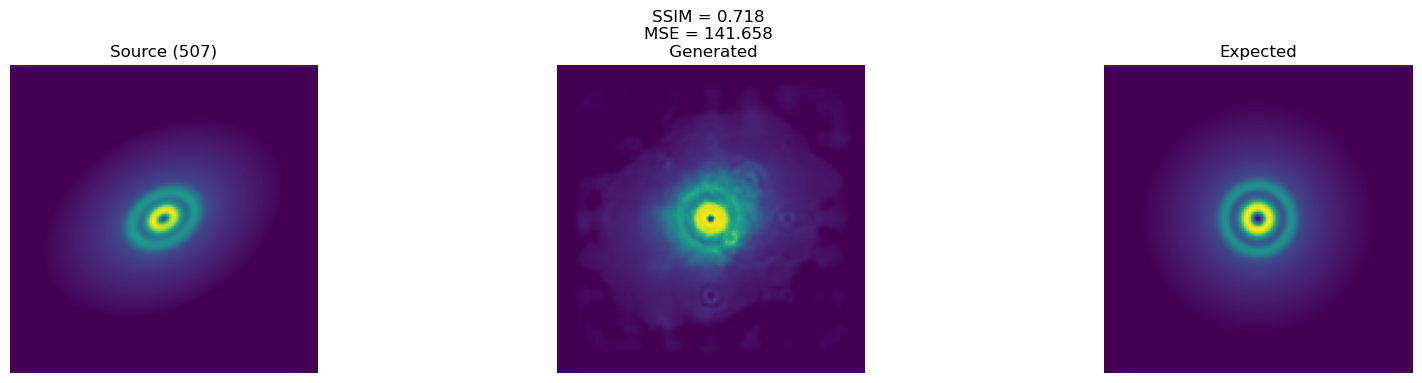

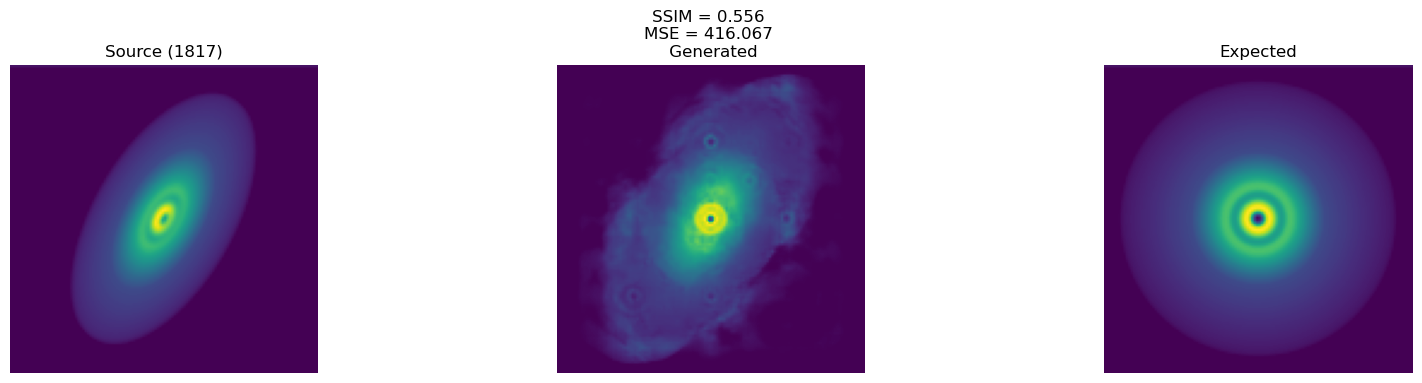

In [16]:
# Calling the plot function

for i in range(3):
    fig, axes = plt.subplots(ncols=3, sharex=False,sharey=True, figsize=(20, 4))
    
    # selecting random example
    ix = randint(0, len(X1), 1)
    # generate image from source
    gen_image_withAttention = g_model_withAttention.predict((X1[ix]-127.5)/127.5)
    # plot all three images
    plot_images_single(X1[ix], ix+1, (gen_image_withAttention+1)*255/2, X2[ix])
    
    display.clear_output(wait=True)

plt.show()

## We may use the previously generated CSV to choose images of specific orientation as our Source Images

_________________________________

## Plot 3 (with and without Attention)

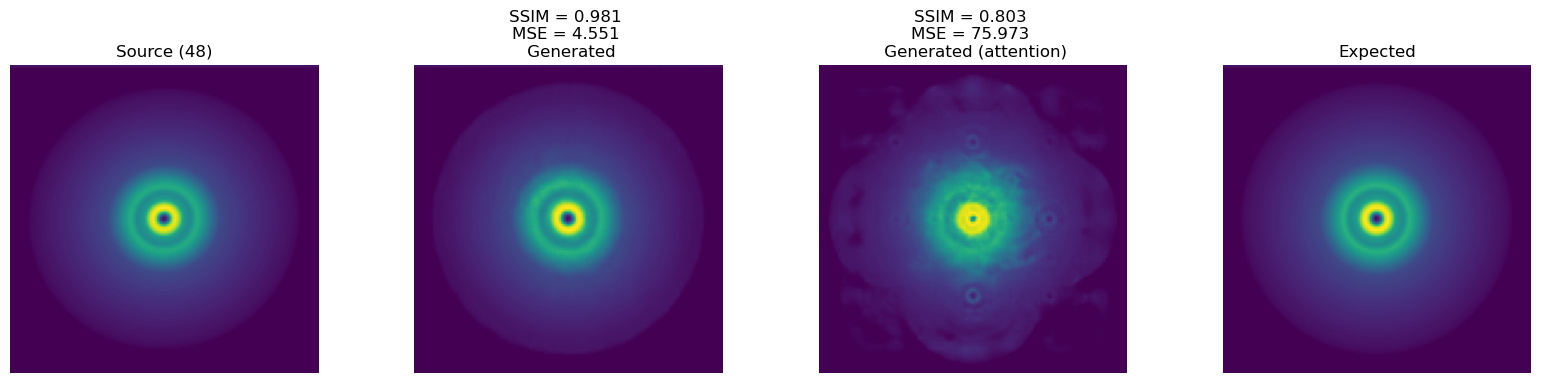

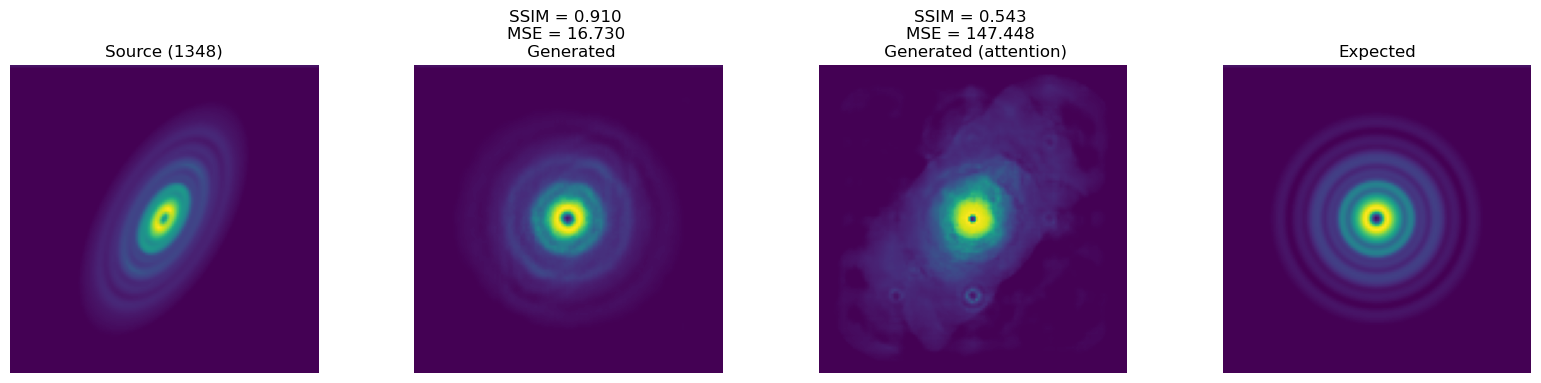

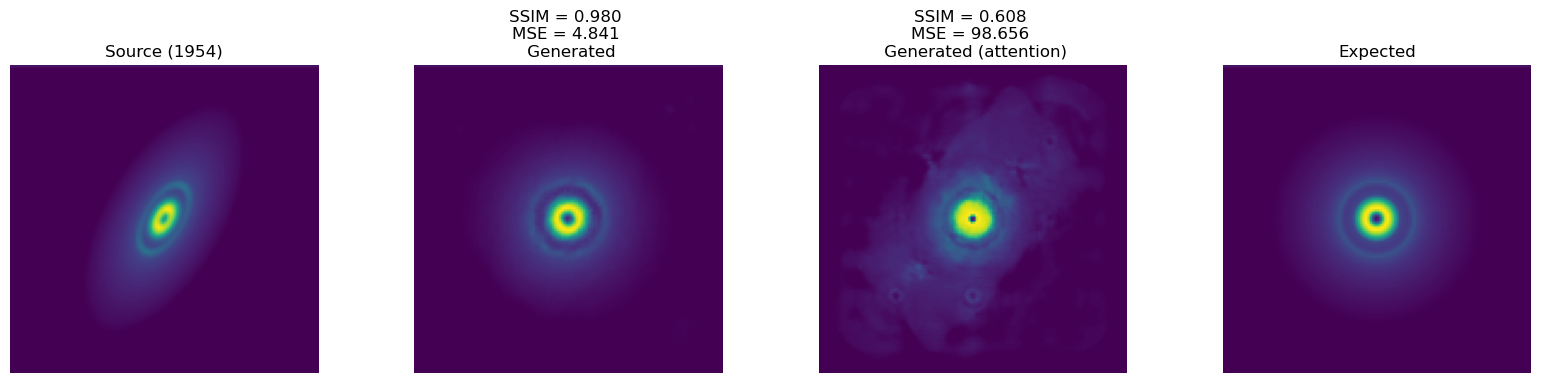

In [20]:
# Calling the plot function

for i in range(3):
    fig, axes = plt.subplots(ncols=4, sharex=False,sharey=True, figsize=(20, 4))
    
    # selecting random example
    ix = randint(0, len(X1), 1)
    # generate image from source
    gen_image_withoutAttention = g_model_withoutAttention.predict((X1[ix]-127.5)/127.5)
    gen_image_withAttention = g_model_withAttention.predict((X1[ix]-127.5)/127.5)
    # plot all three images
    plot_images(X1[ix], ix+1, (gen_image_withoutAttention+1)*255/2, (gen_image_withAttention+1)*255/2, X2[ix])
    
    display.clear_output(wait=True)

plt.show()

## We may use the previously generated CSV to choose images of specific orientation as our Source Images

_________________________

_________________________

# Statistical Analysis of Result
Plots

     1. Histogram:- A histogram will give us a visual representation of the frequency distribution of the SSIM index values. This will help you understand how the values are spread across different ranges.

     2. Box plot:- A box plot (also known as a box-and-whisker plot) will show us the distribution of the SSIM index values, including the median, quartiles, and any outliers. This is useful for understanding the central tendency and variability of the data.

     3. Violin plot:- A violin plot combines aspects of a box plot and a kernel density plot to provide a more comprehensive view of the distribution of the SSIM index values. It can show both the summary statistics and the underlying probability density of the data.

     4. Scatter plot:- If we have paired data or want to explore relationships between different variables, a scatter plot can be useful. We can plot the SSIM index values against another variable (if available) to see if there are any patterns or correlations.


In [21]:
space = ' '*65

def getplot(g_model):
    SSIM, MSE = [], []

    for i in range(len(X2)):
        
        gen_image = g_model.predict((X1[[i]] - 127.5)/127.5)
        images = vstack(((gen_image+1)*255/2, X2[[i]]))
        
        ind1, ind2 = COMPUTE_DIFF(images[0], images[1])

        SSIM.append(ind1)
        MSE.append(ind2)
        
        display.clear_output(wait=True)
        print("Images computed: %d (%d%s)"%(i+1, (i+1)*100//len(X2), '%'))
        print(f"{space}SSIM Index: {ind1:.3f}")
        print(f"{space}MSE Index : {ind2:.3f}")
        
    ## We may use the previously generated CSV to choose images of specific orientation as our Source Images
    return SSIM, MSE

In [22]:
SSIM_withoutAttention, MSE_withoutAttention = getplot(g_model_withoutAttention)
SSIM_withAttention, MSE_withAttention = getplot(g_model_withAttention)
len(SSIM_withoutAttention)

Images computed: 2100 (100%)
                                                                 SSIM Index: 0.568
                                                                 MSE Index : 123.770


2100

### SSIM Index Plot

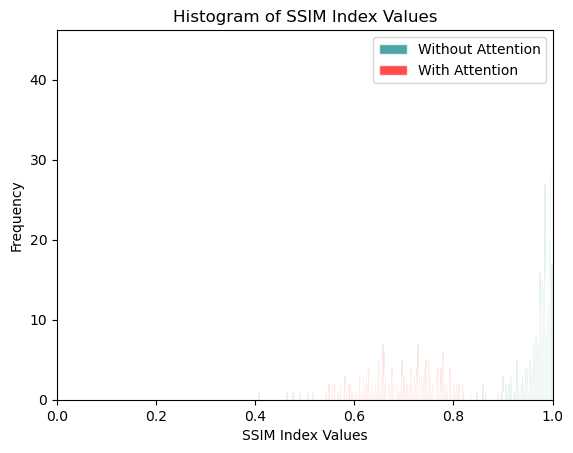

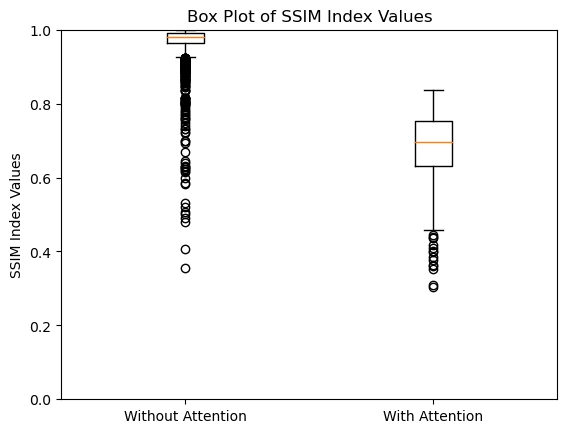

In [23]:
# Plotting both histograms together
plt.hist(SSIM_withoutAttention, bins=2100, edgecolor='white', alpha=0.7, label='Without Attention', color='teal')
plt.hist(SSIM_withAttention, bins=2100, edgecolor='white', alpha=0.7, label='With Attention', color='red')
plt.xlim(0.0, 1.001)
plt.xlabel('SSIM Index Values')
plt.ylabel('Frequency')
plt.title('Histogram of SSIM Index Values')
plt.legend() 
plt.show()

# Plotting box plots for both
plt.boxplot([SSIM_withoutAttention, SSIM_withAttention], labels=['Without Attention', 'With Attention'])
plt.ylim(0.0, 1.0)
plt.ylabel('SSIM Index Values')
plt.title('Box Plot of SSIM Index Values')
plt.show()

#_______________________________________________________________________________________________
# # Plotting a violin plot
# plt.violinplot(SSIM_withoutAttention, showmeans=True)
# plt.ylabel('SSIM Index Values')
# plt.title('Violin Plot of SSIM Index Values')
# plt.show()

# # paired data or another variable to plot against SSIM index values, use a scatter plot

# plt.scatter(SSIM_withoutAttention, testX)
# plt.xlabel('SSIM Index Values')
# plt.ylabel('Paired Data')
# plt.title('Scatter Plot of SSIM Index Values vs. Paired Data')
# plt.show()

### MSE Index Plot

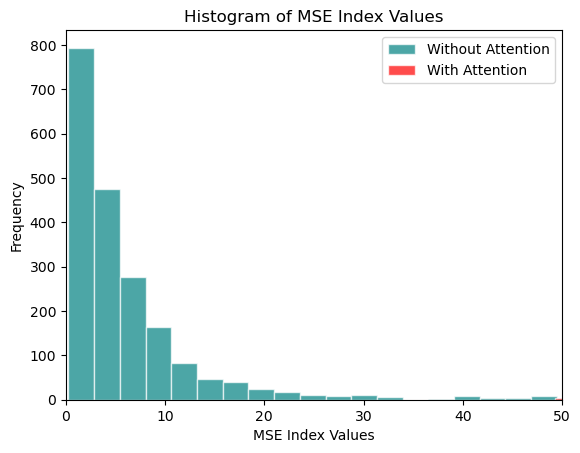

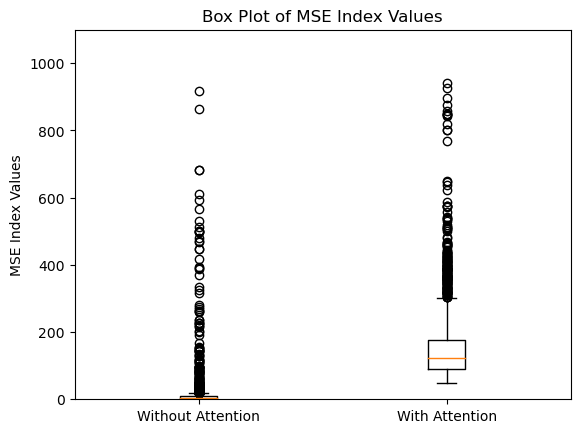

In [24]:
# Plotting both histograms together
plt.hist(MSE_withoutAttention, bins=2100, edgecolor='white', alpha=0.7, label='Without Attention', color='teal')
plt.hist(MSE_withAttention, bins=2100, edgecolor='white', alpha=0.7, label='With Attention', color='red')
plt.xlim(0, 50)
plt.xlabel('MSE Index Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Index Values')
plt.legend() 
plt.show()

# Plotting box plots for both
plt.boxplot([MSE_withoutAttention, MSE_withAttention], labels=['Without Attention', 'With Attention'])
plt.ylim(0, 1100)
plt.ylabel('MSE Index Values')
plt.title('Box Plot of MSE Index Values')
plt.show()

________________________

# Plotting Real Images

In [25]:
def hello_universe(location_of_image):

    real_image = [np.expand_dims(cv2.imread(location_of_image, 0), axis=-1)]
    RI = tf.image.resize(np.asarray(real_image), [pxl, pxl])
    real_image = RI.numpy()
    
    # scale from [0,255] to [-1,1]
    real_image = (real_image - 127.5) / 127.5

    real_img_label = 'Real'
    if('ALMA/' in location_of_image):
        real_img_label = location_of_image.split('ALMA/')
        real_img_label = real_img_label[1][:-4]

    def plot_images_real(src_img, gen_img1, gen_img2):
        images = vstack((src_img, gen_img1, gen_img2))
        # scale from [-1,1] to [0,1]
        images = (images + 1) / 2.0
        titles = [real_img_label, 'Generated without Attention', 'Generated with Attention']
        
        to_return_im = []
        to_return_tl = []
    
        # plot images row by row
        for i in range(len(images)):
            # plot raw pixel data
            to_return_im.append(images[i]*255)
            # show title
            to_return_tl.append(titles[i])
            
        return to_return_im, to_return_tl

    # generate image from source
    gen_image1 = g_model_withoutAttention.predict(real_image)
    gen_image2 = g_model_withAttention.predict(real_image)
    display.clear_output(wait=True)
    return plot_images_real(real_image, gen_image1, gen_image2)

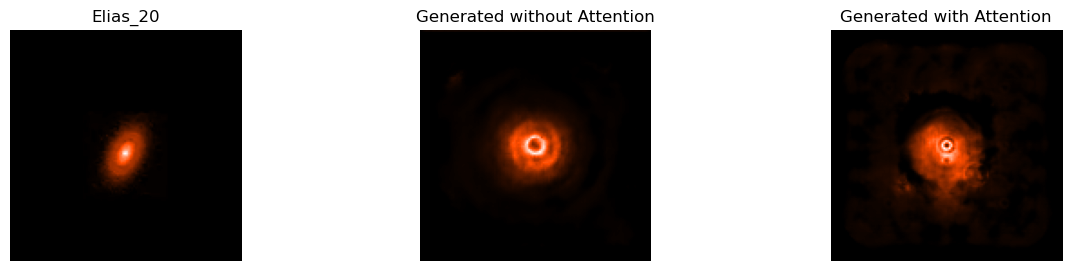

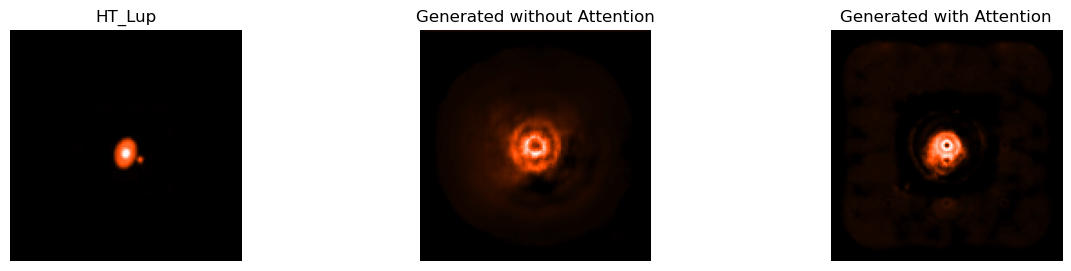

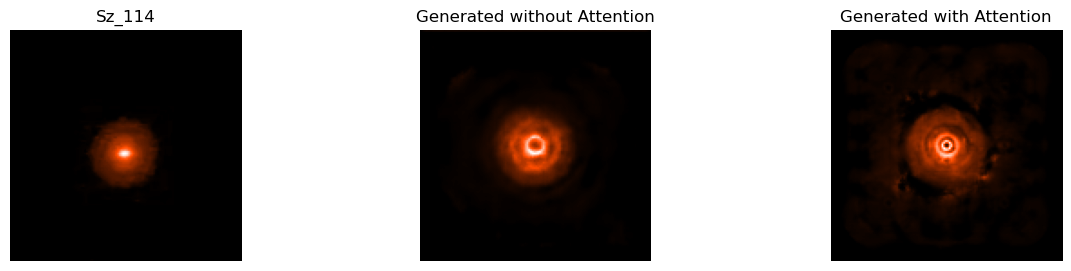

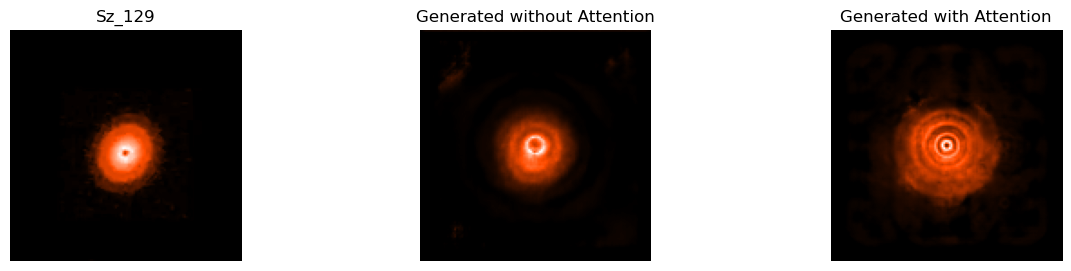

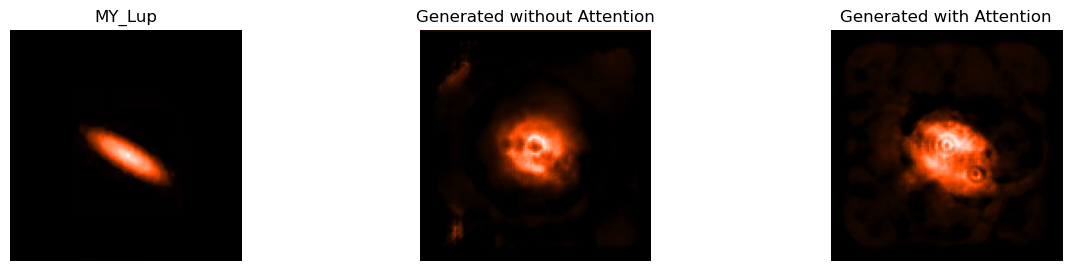

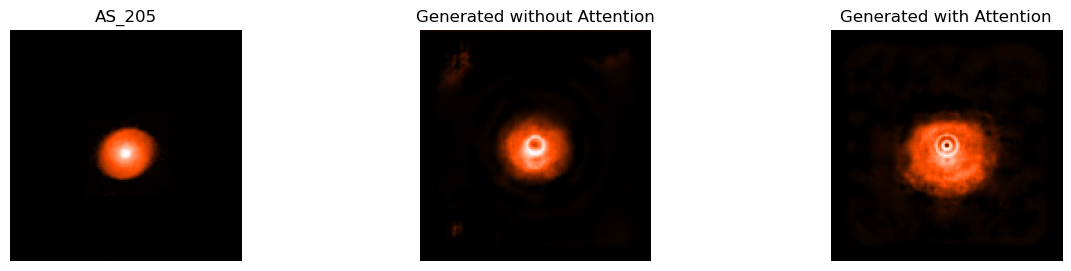

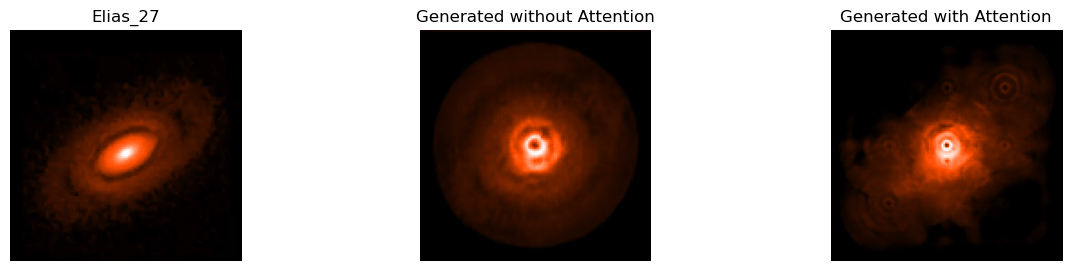

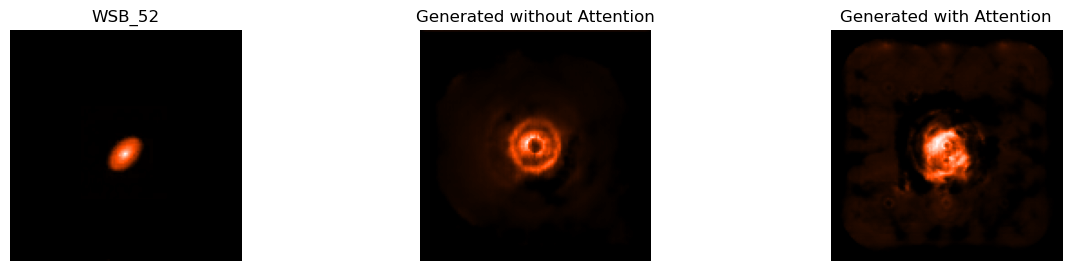

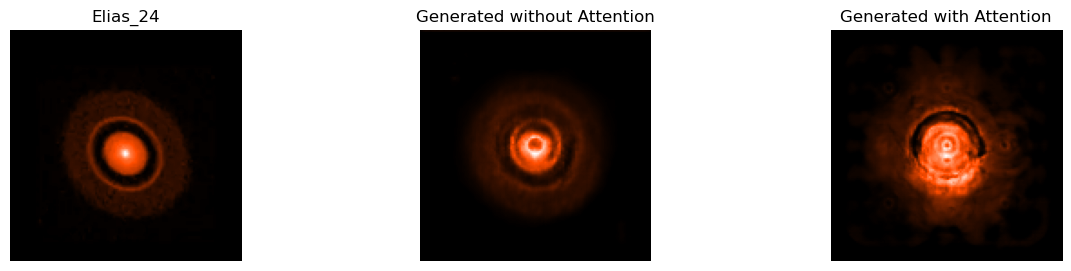

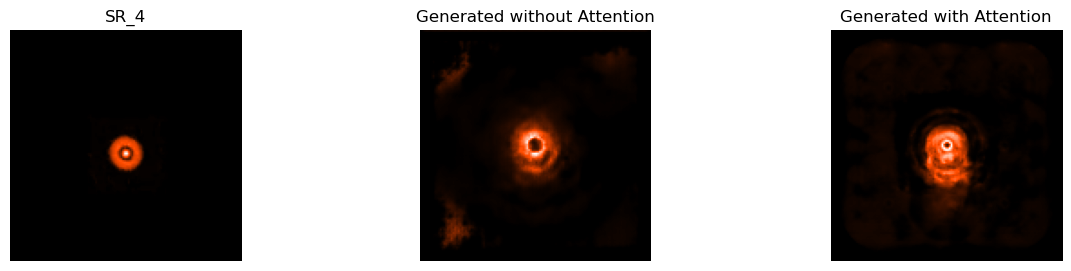

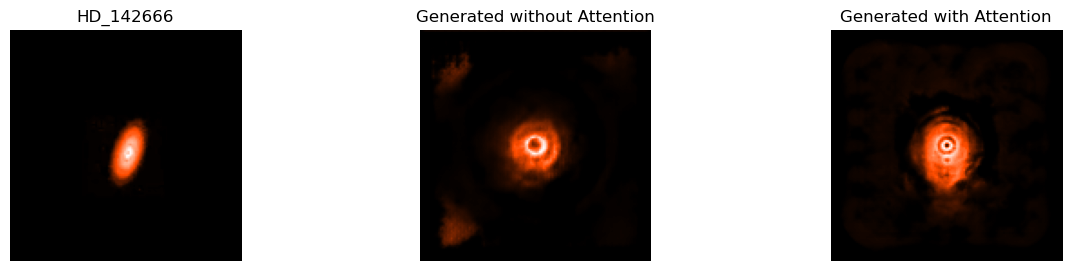

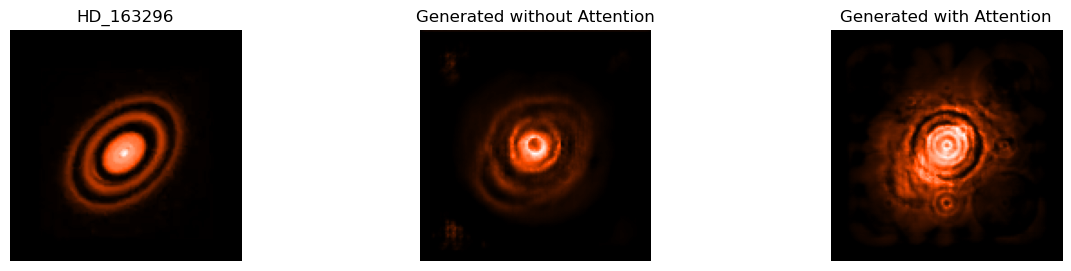

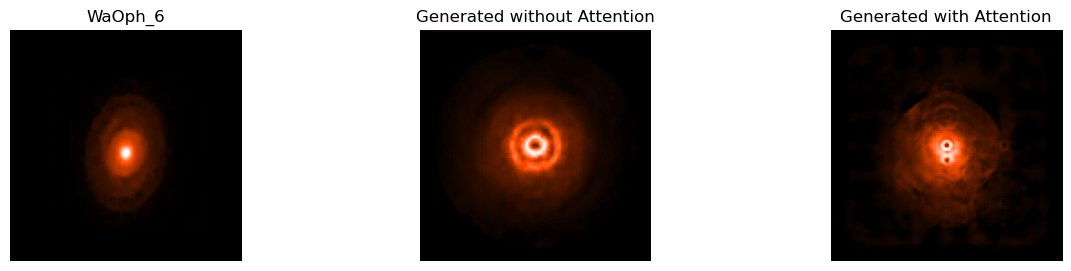

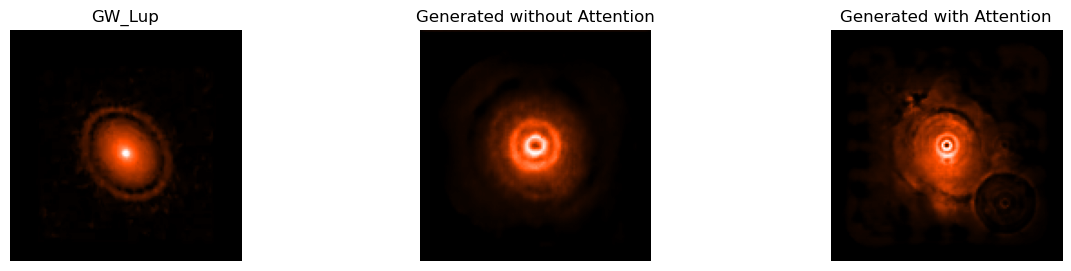

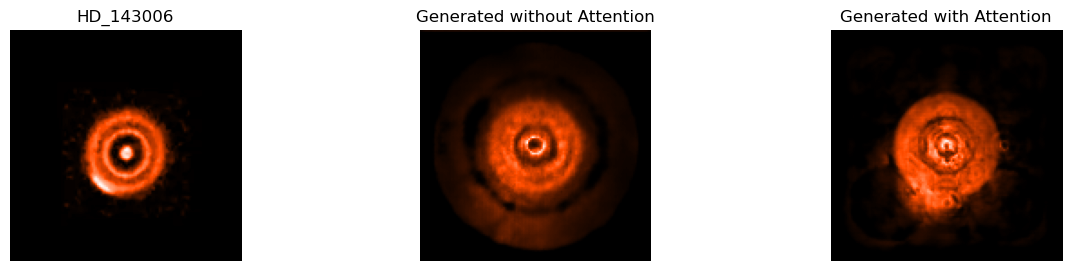

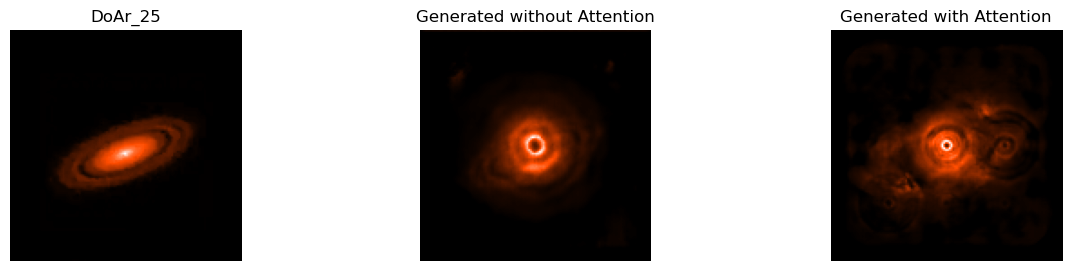

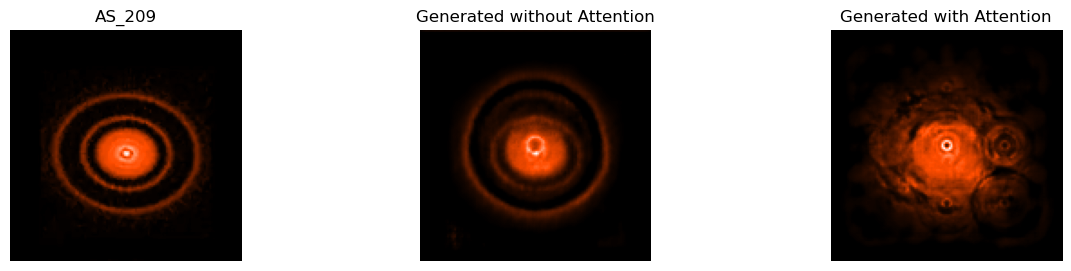

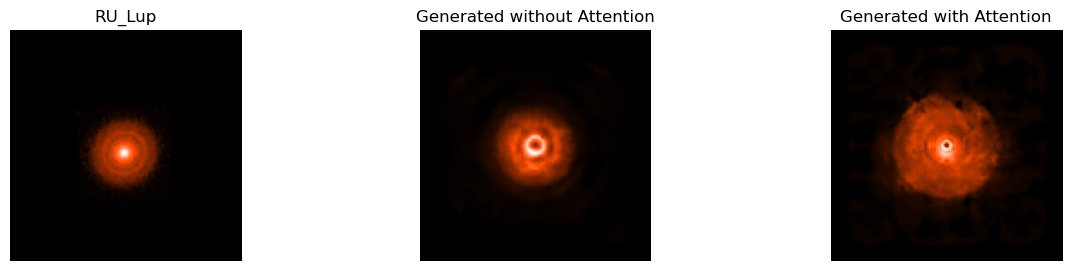

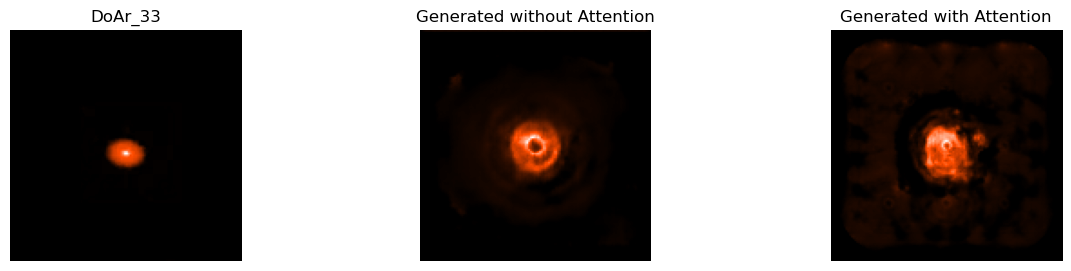

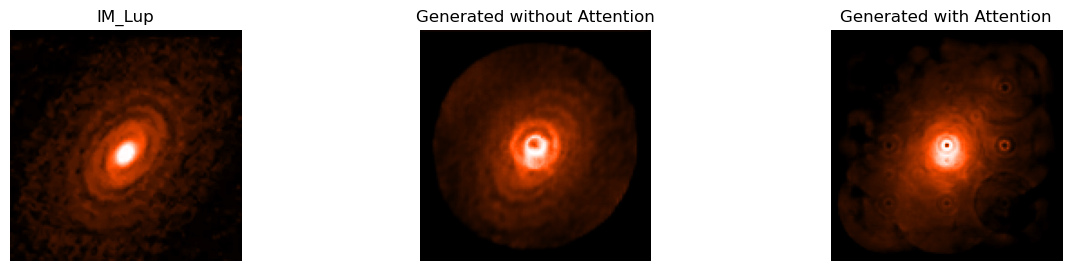

In [26]:
from matplotlib.colors import LinearSegmentedColormap

list_direc = glob.glob('/Users/Dyutiman/Downloads/Original Disk Images/ALMA/*')
# print(list_direc)
col_cntrl = 0
c,d = [],[]

for i in list_direc:
    
    a,b = hello_universe(i)
    c.extend(a)
    d.extend(b)
    col_cntrl = col_cntrl+1
    
    fig, axes = plt.subplots(ncols=3, sharex=False,sharey=True, figsize=(15, 3))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        # turn off axis
        plt.axis('off')

        # Define a custom colormap that transitions from black to orange to white
        colors = [(0, 0, 0), (1, 0.3, 0), (1, 1, 1)]
        custom_cmap = LinearSegmentedColormap.from_list("ALMA_cmap", colors, N=256)
        # Plot the PPD image with the custom colormap
        plt.imshow(c[i], cmap=custom_cmap)

        # Set the plot background to black
#         plt.gca().set_facecolor('black')

        # show title
        plt.title(d[i])
    c = []
    d = []
    
plt.show()

________________________

<hr style="border: 3px solid #333333;">
<hr style="border: 5px solid #333333;">

<hr>

###### Preparing CSV for the code 

In [ ]:
import csv

incl_list = [0., 15., 30., 45., 60.]
# phi_list = [0.]
posang_list = [0., 15., 30., 45., 60., 75.]
pointaux_list = [0., 2.5, 5.0, 7.5, 10.0]

csvvv = []

f=1
for i in incl_list:
#     for j in phi_list:
        for k in posang_list:
            for l in pointaux_list:
                if(l==0):
                    csvvv.append([f, i, k])
                f=f+1

with open('/Users/Dyutiman/Documents/ML_Project/Pix2Pix/RT_Dataset_incl_posang.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'incl', 'posang'])  # Write header
    writer.writerows(csvvv)  # Write data rows


In [85]:
# Load the image
image_path = '/Users/Dyutiman/Downloads/Original Disk Images/20181212-Andrews-et-al-All-disks-1230x1536.webp'
img = Image.open(image_path)

# List of names for the individual images, with spaces replaced by underscores
names = ["AS_205", "AS_209", "DoAr_25", "DoAr_33", "Elias_20", "Elias_24", "Elias_27", 
         "GW_Lup", "HD_142666", "HD_143006", "HD_163296", "HT_Lup", "IM_Lup", "MY_Lup", 
         "RU_Lup", "SR_4", "Sz_114", "Sz_129", "WaOph_6", "WSB_52"]

# Dimensions of the grid and individual images
rows = 5
cols = 4
img_width, img_height = img.size
single_width = img_width // cols
single_height = img_height // rows

# Estimated height of the name label area to crop out (you may need to adjust this)
label_height = 50  # You can adjust this value as needed

# Loop to save each individual image
for row in range(rows):
    for col in range(cols):
        left = col * single_width
        upper = row * single_height
        right = left + single_width
        lower = upper + single_height - label_height
        
        single_img = img.crop((left+label_height/2, upper, right-label_height/2, lower))
        name_index = row * cols + col
        single_img.save(f'{names[name_index]}.png')

print("Individual images saved successfully.")


Individual images saved successfully.


________________________

End of code!